In [1]:
 %matplotlib inline
import seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_dir = os.path.join(os.getcwd(), '../boreal_data')

carbon = pd.read_csv(os.path.join(data_dir, 'Carbon_storage.csv'))
HA = pd.read_csv(os.path.join(data_dir, 'Combined_HA.csv'))
deadwood = pd.read_csv(os.path.join(data_dir, 'Deadwood_volume.csv'))
revenue = pd.read_csv(os.path.join(data_dir, 'Timber_revenues.csv'))

In [3]:
carbon_clean = carbon.dropna(axis=0, how='any')
HA_clean = HA.dropna(axis=0, how='any')
deadwood_clean = deadwood.dropna(axis=0, how='any')
revenue_clean = revenue.dropna(axis=0, how='any')

In [4]:
print('Size of the original dataset: %r' % len(carbon))
carbon.describe()

Size of the original dataset: 29666


,BAU,SA,EXT10,EXT30,GTR30,NTSR,NTLR
count,29666.000000,29666.000000,18156.000000,18156.000000,18124.000000,29666.000000,17847.000000
mean,93.542363,149.333008,114.676874,154.363833,105.624315,97.043721,116.497451
std,87.569930,153.393324,104.095941,140.609791,94.791551,93.647250,110.303848
min,0.528391,0.703060,0.702948,0.703060,0.528391,0.528992,0.528992
25%,33.240975,45.768475,41.986375,55.028475,39.033875,33.549600,42.137100
50%,68.769550,101.406000,86.173850,114.882500,79.590100,70.569900,86.482300
75%,126.093000,198.893000,155.087000,210.267500,143.225500,130.455000,157.002000
max,1315.320000,2059.990000,1687.460000,1877.590000,1358.400000,1308.370000,1854.630000


In [5]:
print('Size of cleaned dataset: % r' % len(carbon_clean))
carbon_clean.describe()

Size of cleaned dataset: 16793


,BAU,SA,EXT10,EXT30,GTR30,NTSR,NTLR
count,16793.000000,16793.000000,16793.000000,16793.000000,16793.000000,16793.000000,16793.000000
mean,98.732481,188.227387,113.559685,156.469401,104.104000,96.331336,116.455191
std,89.649480,174.631596,103.489299,142.527008,93.703542,89.691396,110.026271
min,0.528391,0.703060,0.702948,0.703060,0.528391,0.528992,0.528992
25%,36.316700,65.267500,41.605000,55.624800,38.293500,34.432600,42.237300
50%,74.266000,137.998000,85.293000,116.407000,78.513900,71.595400,86.506000
75%,134.002000,256.034000,154.224000,212.758000,141.506000,131.027000,157.088000
max,1315.320000,2059.990000,1687.460000,1877.590000,1358.400000,1308.370000,1854.630000


Objective function as described in the paper "Spatially dynamic forest management to sustain biodiversity and economic returns". So if the value is Nan, then apply the Business as Usual scheme.

In [6]:
def objective_value(obj, x):
    '''
    Sums values of the given column on each row of the
    dataframe. If the value on the given column at 
    some row is Nan, then selects the first value from
    that row (according to the original source of the data)
    '''
    summ = .0
    for ind, col in zip(range(len(x)), x):
        if not np.isnan(obj.iat[ind,col]):
            summ += obj.iat[ind,col]
        else:
            summ += obj.iat[ind,0]
    return summ

In [7]:
carbon_values = pd.DataFrame({'BAU': objective_value(carbon, np.zeros(len(carbon), dtype=int)),
'SA': objective_value(carbon, np.ones(len(carbon), dtype=int)),
'EXT10': objective_value(carbon, np.ones(len(carbon), dtype=int)*2),
'EXT30': objective_value(carbon, np.ones(len(carbon), dtype=int)*3),
'GTR30': objective_value(carbon, np.ones(len(carbon), dtype=int)*4),
'NTSR': objective_value(carbon, np.ones(len(carbon), dtype=int)*5),
'NTLR': objective_value(carbon, np.ones(len(carbon), dtype=int)*6)}, index=pd.Series([1]))

In [8]:
print('Maximum values for all the harvesting schemes using original data:')
carbon_values

Maximum values for all the harvesting schemes using original data:


,BAU,EXT10,EXT30,GTR30,NTLR,NTSR,SA
1,2.775028e+06,3.031424e+06,3.751980e+06,2.865804e+06,3.089092e+06,2.878899e+06,4.430113e+06


In [9]:
clean_carbon_values = pd.DataFrame({'BAU': objective_value(carbon_clean, np.zeros(len(carbon_clean), dtype=int)),
'SA': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)),
'EXT10': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)*2),
'EXT30': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)*3),
'GTR30': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)*4),
'NTSR': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)*5),
'NTLR': objective_value(carbon_clean, np.ones(len(carbon_clean), dtype=int)*6)}, index=pd.Series([1]))

In [10]:
print('Maximum values for all the harvesting schemes using original data:')
clean_carbon_values

Maximum values for all the harvesting schemes using original data:


,BAU,EXT10,EXT30,GTR30,NTLR,NTSR,SA
1,1.658015e+06,1.907008e+06,2.627591e+06,1.748218e+06,1.955632e+06,1.617692e+06,3.160903e+06


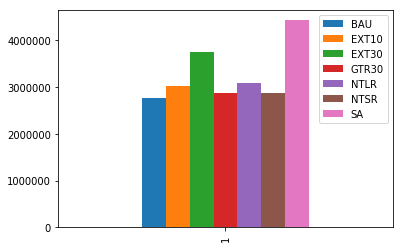

In [11]:
carbon_pic = carbon_values.plot(kind='bar')

Resulting bar-graph looks the same than in the paper..

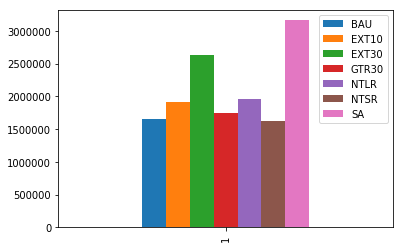

In [12]:
clean_carbon_values.plot(kind='bar')

## Different way to evaluate data with Nan-values

In [13]:
#x = np.array(['NTLR']).repeat(len(carbon))
x = np.ones(len(carbon), dtype=int)*6

In [14]:
%%time 
print(sum([carbon.iat[ind, col] if not np.isnan(carbon.iat[ind, col]) else carbon.iat[ind, 0] for ind,col in zip(range(len(x)), x)]))

3089092.29728
CPU times: user 748 ms, sys: 68 ms, total: 816 ms
Wall time: 743 ms


## Concat data


In [15]:
all = pd.concat([carbon[:5], HA[:5], deadwood[:5]], keys=['Carbon', 'HA','Deadwood'])

In [16]:
type(all)

pandas.core.frame.DataFrame

In [17]:
type(all.loc['Carbon','BAU'])

pandas.core.series.Series

This is not as easy as I thought. It is also important to think what is the most efficient structure for the future use.

# Optimization

Not gonna happen with these computers. There is no suitable libraries and no option to download one.

In [18]:
import scipy.optimize

In [19]:
optimize.linprog(carbon_clean[:5].values.flatten(), 

SyntaxError: unexpected EOF while parsing (<ipython-input-19-72f9ddee0ab8>, line 1)

In [ ]:
carbon_clean[:5].values

# Klustering

### Feature selection

In [ ]:
carbon.corr()

### Klustering according to the features